# HM7_YIMIN LI

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that estimate a deep classification model with Keras (and LSTM) and also BERT in order to predict pre-established data labels relevant to your final project (as for week 3's homework). Which works better? Are the errors the same or different?

<span style="color:red">***Stretch***</span>: <span style="color:red">Now alter the neural network by stacking network layers, adjusting the embedding dimension, compare its performance with your model above, and interpret why it might be different.

## 1.

In [1]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [2]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [3]:
!pip install transformers
!pip install keras

     |████████████████████████████████| 645kB 12.0MB/s 
     |████████████████████████████████| 890kB 41.9MB/s 
     |████████████████████████████████| 1.1MB 47.8MB/s 
     |████████████████████████████████| 3.8MB 49.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=123d320761ec02ca16138c4ea65a683f1d4e34071135cb324677fcf469c411d2
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [0]:
%matplotlib inline

In [5]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [0]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertConfig
from transformers import AdamW, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [7]:
import pandas as pd
import numpy as np
csv_url = "https://raw.githubusercontent.com/minminfly68/Content-Analysis-2020/master/week-7/first5000.csv"
df = pd.read_csv(csv_url)
df.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,5,True,"10 17, 2015",A1HP7NVNPFMA4N,700026657,Ambrosia075,"This game is a bit hard to get the hang of, bu...",but when you do it's great.,1445040000,NaN,NaN,NaN
1,4,False,"07 27, 2015",A1JGAP0185YJI6,700026657,travis,I played it a while but it was alright. The st...,"But in spite of that it was fun, I liked it",1437955200,NaN,NaN,NaN
2,3,True,"02 23, 2015",A1YJWEXHQBWK2B,700026657,Vincent G. Mezera,ok game.,Three Stars,1424649600,NaN,NaN,NaN
3,2,True,"02 20, 2015",A2204E1TH211HT,700026657,Grandma KR,"found the game a bit too complicated, not what...",Two Stars,1424390400,NaN,NaN,NaN
4,5,True,"12 25, 2014",A2RF5B5H74JLPE,700026657,jon,"great game, I love it and have played it since...",love this game,1419465600,NaN,NaN,NaN


In [8]:
# We try to predict based on text whether we can infer how much stars the reviewers might give
# We manually label five stars = 1, others = 0
df['overall'].value_counts()

5    3388
4     880
3     376
1     192
2     164
Name: overall, dtype: int64

In [9]:
df = df[['overall', 'reviewerID', 'reviewText']]
df['label'] = df.apply(lambda x: int(x['overall'] == 5), axis=1)
df = df[['label', 'reviewerID', 'reviewText']]
df.head()

,label,reviewerID,reviewText
0,1,A1HP7NVNPFMA4N,"This game is a bit hard to get the hang of, bu..."
1,0,A1JGAP0185YJI6,I played it a while but it was alright. The st...
2,0,A1YJWEXHQBWK2B,ok game.
3,0,A2204E1TH211HT,"found the game a bit too complicated, not what..."
4,1,A2RF5B5H74JLPE,"great game, I love it and have played it since..."


In [0]:
# Create sentence and label lists
sentences = df.reviewText.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values

In [11]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])


Tokenize the first sentence:
['[CLS]', 'this', 'game', 'is', 'a', 'bit', 'hard', 'to', 'get', 'the', 'hang', 'of', ',', 'but', 'when', 'you', 'do', 'it', "'", 's', 'great', '.', '[SEP]']


In [0]:
MAX_LEN = 128

In [0]:
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

In [0]:
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [0]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

In [0]:
# Use train_test_split to split our data into train and validation sets for training
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2020, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2020, test_size=0.1)

## Deep Neural Nets

In [0]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding

In [0]:
vocab_in_size = tokenizer.vocab_size
embedding_dim = 32
unit = 100
no_labels = len(np.unique(train_labels))
batch_size = 32

In [33]:
model_lstm = Sequential()
model_lstm.add(Embedding(vocab_in_size, embedding_dim, input_length=MAX_LEN))
model_lstm.add(LSTM(unit))
model_lstm.add(Dense(no_labels, activation='softmax'))
model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 128, 32)           976704    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 202       
Total params: 1,030,106
Trainable params: 1,030,106
Non-trainable params: 0
_________________________________________________________________


In [34]:
history_lstm = model_lstm.fit(train_inputs, train_labels, 
                              epochs=10,batch_size=batch_size)

Epoch 1/10
4500/4500 [==============================] - 31s 7ms/step - loss: 0.6249 - accuracy: 0.6758
Epoch 2/10
4500/4500 [==============================] - 29s 6ms/step - loss: 0.6035 - accuracy: 0.6987
Epoch 3/10
4500/4500 [==============================] - 28s 6ms/step - loss: 0.5381 - accuracy: 0.7558
Epoch 4/10
4500/4500 [==============================] - 28s 6ms/step - loss: 0.6088 - accuracy: 0.6798
Epoch 5/10
4500/4500 [==============================] - 28s 6ms/step - loss: 0.5047 - accuracy: 0.7704
Epoch 6/10
4500/4500 [==============================] - 28s 6ms/step - loss: 0.5450 - accuracy: 0.7584
Epoch 7/10
4500/4500 [==============================] - 28s 6ms/step - loss: 0.4611 - accuracy: 0.8029
Epoch 8/10
4500/4500 [==============================] - 28s 6ms/step - loss: 0.4631 - accuracy: 0.8096
Epoch 9/10
4500/4500 [==============================] - 28s 6ms/step - loss: 0.4016 - accuracy: 0.8324
Epoch 10/10
4500/4500 [==============================] - 27s 6ms/step - l

The General model (LSTM) performs fairly ok in our dataset but with quite great variance. It can predict good classification in around 67% - 85%. Adding one more layer is more time consuming, but based on my test on small dataset, it would not significantly influence our result.

## BERT

In [0]:
# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [0]:
# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
batch_size = 32

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [37]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [0]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [0]:
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [0]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [0]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [0]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [43]:
import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    141.    Elapsed: 0:00:16.
  Batch    80  of    141.    Elapsed: 0:00:31.
  Batch   120  of    141.    Elapsed: 0:00:46.

  Average training loss: 0.53
  Training epcoh took: 0:00:54

Running Validation...
  Accuracy: 0.78
  Validation took: 0:00:02

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    141.    Elapsed: 0:00:15.
  Batch    80  of    141.    Elapsed: 0:00:30.
  Batch   120  of    141.    Elapsed: 0:00:45.

  Average training loss: 0.40
  Training epcoh took: 0:00:53

Running Validation...
  Accuracy: 0.81
  Validation took: 0:00:02

======== Epoch 3 / 4 ========
Training...
  Batch    40  of    141.    Elapsed: 0:00:15.
  Batch    80  of    141.    Elapsed: 0:00:30.
  Batch   120  of    141.    Elapsed: 0:00:45.

  Average training loss: 0.30
  Training epcoh took: 0:00:53

Running Validation...
  Accuracy: 0.80
  Validation took: 0:00:02

======== Epoch 4 / 4 ========
Training...
  Batch    40  of 

In [44]:
loss_values

[0.5259505567398477,
 0.39601450376476804,
 0.29674616947453075,
 0.22333387803312735]

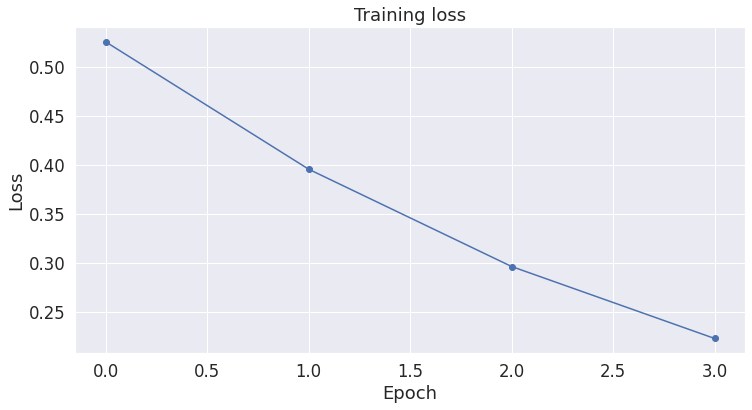

In [45]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

As we can see from the data above, BERT performs similar with LSTM, with an accuracy rate at around 78-81% and its variance is smaller than LSTM. As graph shows above, as epoch number increases, the average training loss decreases, having better prediction.

## Model Evaluation

In [47]:
# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df.shape[0]))

# Create sentence and label lists
sentences = df.reviewText.values
labels = df.label.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   )
    
    input_ids.append(encoded_sent)

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, 
                          dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask) 

# Convert to tensors.
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Token indices sequence length is longer than the specified maximum sequence length for this model (658 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (665 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (570 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (528 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (746 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

Number of test sentences: 5,000



Token indices sequence length is longer than the specified maximum sequence length for this model (520 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (642 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (566 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (631 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (593 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

In [48]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)

    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch

    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 5,000 test sentences...
    DONE.


In [49]:
print('Positive samples: %d of %d (%.2f%%)' % (df.label.sum(), len(df.label), (df.label.sum() / len(df.label) * 100.0)))

Positive samples: 3388 of 5000 (67.76%)


In [50]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):

    # The predictions for this batch are a 2-column ndarray (one column for "0" 
    # and one column for "1"). Pick the label with the highest value and turn this
    # in to a list of 0s and 1s.
    pred_labels_i = np.argmax(predictions[i], axis=1).flatten()

    # Calculate and store the coef for this batch.  
    matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
    matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


In [53]:
# Combine the predictions for each batch into a single list of 0s and 1s.
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true_labels for item in sublist]

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('MCC: %.3f' % mcc)

MCC: 0.845


In [54]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))

Saving model to ./model_save/


('./model_save/vocab.txt',
 './model_save/special_tokens_map.json',
 './model_save/added_tokens.json')

As we can see, this model has MCC of 0.845, meaning excellent prediction in whether a model is a five-star comment

The huggingface/transformers repository lists the other pipeline functions, such as ner extraction, sequence classification, and masking. You are encouraged to explore them. 
https://github.com/huggingface/transformers#quick-tour-of-pipelines

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">In the cells immediately following, use the pipeline functions or the word or sentence vector functions (e.g., similarity) to explore the social game underlying the production and meaning of texts associated with your final project. You have used similar, but often weaker versions in previous weeks. How does BERT help you gain insight regarding your research question that is similar and different from prior methods?

## Embeddings, Context Words

In [0]:
from transformers import BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [0]:
# Map the token strings to their vocabulary indeces.
indexed_tokens = [tokenizer.convert_tokens_to_ids(text) for text in tokenized_texts]
indexed_tokens = pad_sequences(indexed_tokens, maxlen=128, dtype="long", truncating="post", padding="post")

## Segement ID

In [0]:
segment_ids = [100 * [1] for index in tokenized_texts]

In [0]:
# Convert inputs to PyTorch tensors
tokens_tensor = torch.tensor(indexed_tokens[:50])
segments_tensors = torch.tensor(segment_ids[:50])

In [15]:
# Load pre-trained model (weights)
model_embedding = BertModel.from_pretrained('bert-base-uncased')

# Put the model in "evaluation" mode, meaning feed-forward operation.
model_embedding.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [0]:
output = model_embedding(tokens_tensor)

## Understanding the Output

In [0]:
word_embeddings, sentence_embedding = output

In [18]:
word_embeddings[0]

tensor([[-0.5190,  0.2969,  0.4654,  ..., -0.4119,  0.4396, -0.8465],
        [-0.4679,  0.1030, -0.3807,  ..., -0.3009,  0.9709,  0.4252],
        [ 0.0908, -0.7265,  0.5576,  ..., -0.3146,  0.1447,  0.1999],
        ...,
        [ 0.3638, -0.3650,  0.8420,  ..., -0.8527, -0.1828, -1.0350],
        [ 0.3207, -0.1622,  0.8025,  ..., -0.8076, -0.3259, -1.0507],
        [ 0.3537, -0.0855,  0.7437,  ..., -0.8039, -0.3248, -1.2958]],
       grad_fn=<SelectBackward>)

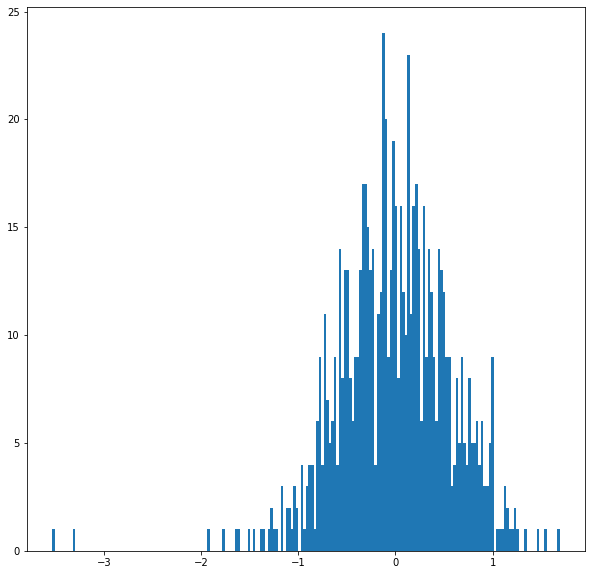

In [19]:
vec = word_embeddings[0][0]
vec = vec.detach().numpy()
# Plot the values as a histogram to show their distribution.
plt.figure(figsize=(10,10))
plt.hist(vec, bins=200)
plt.show()

As is shown in the graph, the majority of values fall between [-1, 1]

## Sentence Vector

In [0]:
token_vecs = []
# For each token in the sentence...
for embedding in word_embeddings[0]:
    cat_vec = embedding.detach().numpy()
    # Use `cat_vec` to represent `token`.
    token_vecs.append(cat_vec)

In [21]:
for i, token_str in enumerate(tokenized_texts[0]):
    print(i, token_str)

0 [CLS]
1 this
2 game
3 is
4 a
5 bit
6 hard
7 to
8 get
9 the
10 hang
11 of
12 ,
13 but
14 when
15 you
16 do
17 it
18 '
19 s
20 great
21 .
22 [SEP]


In [22]:
print('')
print("this game   ", str(token_vecs[2][:5]))
print("bit hard  ", str(token_vecs[6][:5]))


this game    [ 0.09082028 -0.7264875   0.5576084   0.03801588  0.17322066]
bit hard   [-0.83949304 -0.10810888  0.43305808 -0.06664655 -0.7684753 ]


## Transformers Pipeline

In [23]:
from transformers import pipeline
# Allocate a pipeline for sentiment-analysis
nlp_sentiment = pipeline('sentiment-analysis')

In [26]:
# sen_sentiment = [nlp_sentiment(sen2) for sen2 in sentences[:19]]

sen_sentiment = []
for i in range(1000):
  try:
    sen_sentiment.append(nlp_sentiment(sentences[i]))
  except:
    print("index {} : Senetence is too long".format(i))
sen_sentiment[:5]

index 18 : Senetence is too long
index 19 : Senetence is too long
index 37 : Senetence is too long
index 42 : Senetence is too long
index 45 : Senetence is too long
index 92 : Senetence is too long
index 93 : Senetence is too long
index 160 : Senetence is too long
index 167 : Senetence is too long
index 283 : Senetence is too long
index 411 : Senetence is too long
index 422 : Senetence is too long
index 431 : Senetence is too long
index 435 : Senetence is too long
index 436 : Senetence is too long
index 440 : Senetence is too long
index 454 : Senetence is too long
index 463 : Senetence is too long
index 498 : Senetence is too long
index 506 : Senetence is too long
index 521 : Senetence is too long
index 525 : Senetence is too long
index 530 : Senetence is too long
index 532 : Senetence is too long
index 533 : Senetence is too long
index 541 : Senetence is too long
index 574 : Senetence is too long
index 585 : Senetence is too long
index 587 : Senetence is too long
index 588 : Senetence

[[{'label': 'POSITIVE', 'score': 0.9998044967651367}],
 [{'label': 'POSITIVE', 'score': 0.9994499683380127}],
 [{'label': 'POSITIVE', 'score': 0.9998160600662231}],
 [{'label': 'NEGATIVE', 'score': 0.9997512102127075}],
 [{'label': 'POSITIVE', 'score': 0.9998770356178284}]]

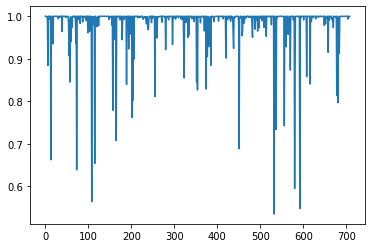

In [36]:
com_pos = []
com_neg = []
for i in range(len(sen_sentiment)):
  if sen_sentiment[i][0]['label'] == 'POSITIVE':
    com_pos.append(sen_sentiment[i][0]['score'])
  else:
    com_neg.append(-sen_sentiment[i][0]['score'])
plt.plot(com_pos)

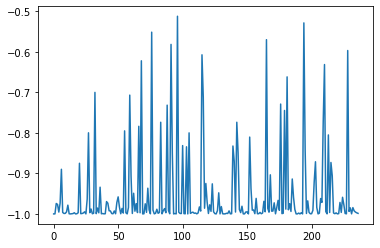

In [37]:
plt.plot(com_neg)

From the EDA Analysis above, we can see that around 750 sentences are positive while the remianing 250 is negative comments. We can also infer that those positive comments have much stronger sentimental score than the negative comments.

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">Construct cells immediately below this that generate a BERT-powered chatbot tuned on text related to your final project. What is interesting about this model, and how to does it compare to an untrained model? What does it reveal about the social game involved with your dataset?

In [12]:
from transformers import AutoModelWithLMHead, AutoTokenizer

tokenizer_gpt = AutoTokenizer.from_pretrained("gpt2")
model_gpt = AutoModelWithLMHead.from_pretrained("gpt2")

In [0]:
from sklearn.model_selection import train_test_split
train_text, test_text = train_test_split(df['reviewText'], test_size=0.2)

In [0]:
train_text.to_frame().to_csv(r'train_text', header=None, index=None, sep=' ', mode='a')
test_text.to_frame().to_csv(r'test_text', header=None, index=None, sep=' ', mode='a')

In [20]:
train_text.head()

1501    This game is great!!!!!!! I played a friends, ...
2272                                           great game
1777    I am a latecomer to Tenchu. Since it is a PS1 ...
649     I have got to be honest even if it means sacki...
3810    after the fantastic Saturn,  sega took a break...
Name: reviewText, dtype: object

In [0]:
torch.cuda.empty_cache() 

In [22]:
!python run_language_modelling.py --output_dir=output_gpt_text --model_type=gpt2 --model_name_or_path=gpt2 --do_train --train_data_file=train_text --do_eval --eval_data_file=test_text --per_gpu_train_batch_size=1 --per_gpu_eval_batch_size=1

2020-05-22 03:01:23.188713: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
05/22/2020 03:01:24 - WARNING - __main__ -   Process rank: -1, device: cuda, n_gpu: 1, distributed training: False, 16-bits training: False
05/22/2020 03:01:25 - INFO - transformers.configuration_utils -   loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/gpt2-config.json from cache at /root/.cache/torch/transformers/4be02c5697d91738003fb1685c9872f284166aa32e061576bbe6aaeb95649fcf.db13c9bc9c7bdd738ec89e069621d88e05dc670366092d809a9cbcac6798e24e
05/22/2020 03:01:25 - INFO - transformers.configuration_utils -   Model config GPT2Config {
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_e

In [23]:
!python run_generation.py --model_type=gpt2 --model_name_or_path=output_gpt_text

2020-05-22 03:10:01.223360: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
05/22/2020 03:10:02 - INFO - transformers.tokenization_utils -   Model name 'output_gpt_text' not found in model shortcut name list (gpt2, gpt2-medium, gpt2-large, gpt2-xl, distilgpt2). Assuming 'output_gpt_text' is a path, a model identifier, or url to a directory containing tokenizer files.
05/22/2020 03:10:02 - INFO - transformers.tokenization_utils -   Didn't find file output_gpt_text/added_tokens.json. We won't load it.
05/22/2020 03:10:02 - INFO - transformers.tokenization_utils -   loading file output_gpt_text/vocab.json
05/22/2020 03:10:02 - INFO - transformers.tokenization_utils -   loading file output_gpt_text/merges.txt
05/22/2020 03:10:02 - INFO - transformers.tokenization_utils -   loading file None
05/22/2020 03:10:02 - INFO - transformers.tokenization_utils -   loading file output_gpt_text/special_tokens_map.json
05/22/2020 03:

This was so interesting that it shows the high-level pattern of text generation that highlighting this video is innovative and fun, which is quite positive.

In [0]:
tokenizer_gpt = AutoTokenizer.from_pretrained("output_gpt_text")
model_gpt = AutoModelWithLMHead.from_pretrained("output_gpt_text")

In [28]:
sequence = "I like this video game because"

input = tokenizer_gpt.encode(sequence, return_tensors="pt")
generated = model_gpt.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_gpt.decode(generated.tolist()[0])
print(resulting_string)

I like this video game because it's fun and it's fun to play. I also like the fact that you can play as a character and have a lot of fun. I also like the fact that you can play as a character and have a


In [29]:
sequence = "I don't like this video game because"

input = tokenizer_gpt.encode(sequence, return_tensors="pt")
generated = model_gpt.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_gpt.decode(generated.tolist()[0])
print(resulting_string)

I don't like this video game because it's so boring.  I don't like the graphics, but I like the gameplay.  I like the story, but I don't like the characters.  I like the music, but I don


It is so interesting that we can see the two text generations from positive and negative perspective.

After that, We construct two new datasets each with labelled as 1 and 0 respectively with 1000 inputs.Then, we try to see different text generations from them.

In [55]:
import pandas as pd
import numpy as np
csv_url = "https://raw.githubusercontent.com/minminfly68/Content-Analysis-2020/master/week-7/first5000.csv"
df_all = pd.read_csv(csv_url)
df_all = df_all[['overall', 'reviewText']]
df_all['label'] = df_all.apply(lambda x: int(x['overall'] == 5), axis=1)
df_all = df_all[['label','reviewText']]
df_all.head()

,label,reviewText
0,1,"This game is a bit hard to get the hang of, bu..."
1,0,I played it a while but it was alright. The st...
2,0,ok game.
3,0,"found the game a bit too complicated, not what..."
4,1,"great game, I love it and have played it since..."


In [56]:
df_1 = df_all[df_all['label'] == 1]
df_1 = df_1[:500]
print(df_1.head())
df_0 = df_all[df_all['label'] == 0]
df_0 = df_0[:500]
print(df_0.head())

    label                                         reviewText
0       1  This game is a bit hard to get the hang of, bu...
4       1  great game, I love it and have played it since...
7       1  I bought this game thinking it would be pretty...
8       1  I have played the old anno 1701 AND 1503.  thi...
12      1  Loved playing Dirt 2 and I thought the graphic...
   label                                         reviewText
1      0  I played it a while but it was alright. The st...
2      0                                           ok game.
3      0  found the game a bit too complicated, not what...
5      0  i liked a lot some time that i haven't play a ...
6      0  I'm an avid gamer, but Anno 2070 is an INSULT ...


In [0]:
from sklearn.model_selection import train_test_split
train_text, test_text = train_test_split(df_1['reviewText'], test_size=0.2)
train_text.to_frame().to_csv(r'train_text', header=None, index=None, sep=' ', mode='a')
test_text.to_frame().to_csv(r'test_text', header=None, index=None, sep=' ', mode='a')

In [0]:
torch.cuda.empty_cache() 

In [59]:
!python run_language_modelling.py --output_dir=output_gpt_text_1 --model_type=gpt2 --model_name_or_path=gpt2 --do_train --train_data_file=train_text --do_eval --eval_data_file=test_text --per_gpu_train_batch_size=1 --per_gpu_eval_batch_size=1

2020-05-22 03:37:45.902575: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
05/22/2020 03:37:47 - WARNING - __main__ -   Process rank: -1, device: cuda, n_gpu: 1, distributed training: False, 16-bits training: False
05/22/2020 03:37:48 - INFO - transformers.configuration_utils -   loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/gpt2-config.json from cache at /root/.cache/torch/transformers/4be02c5697d91738003fb1685c9872f284166aa32e061576bbe6aaeb95649fcf.db13c9bc9c7bdd738ec89e069621d88e05dc670366092d809a9cbcac6798e24e
05/22/2020 03:37:48 - INFO - transformers.configuration_utils -   Model config GPT2Config {
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_e

In [60]:
!python run_generation.py --model_type=gpt2 --model_name_or_path=output_gpt_text_1

2020-05-22 03:47:14.725169: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
05/22/2020 03:47:16 - INFO - transformers.tokenization_utils -   Model name 'output_gpt_text_1' not found in model shortcut name list (gpt2, gpt2-medium, gpt2-large, gpt2-xl, distilgpt2). Assuming 'output_gpt_text_1' is a path, a model identifier, or url to a directory containing tokenizer files.
05/22/2020 03:47:16 - INFO - transformers.tokenization_utils -   Didn't find file output_gpt_text_1/added_tokens.json. We won't load it.
05/22/2020 03:47:16 - INFO - transformers.tokenization_utils -   loading file output_gpt_text_1/vocab.json
05/22/2020 03:47:16 - INFO - transformers.tokenization_utils -   loading file output_gpt_text_1/merges.txt
05/22/2020 03:47:16 - INFO - transformers.tokenization_utils -   loading file None
05/22/2020 03:47:16 - INFO - transformers.tokenization_utils -   loading file output_gpt_text_1/special_tokens_map.json
05

In [0]:
from sklearn.model_selection import train_test_split
train_text, test_text = train_test_split(df_0['reviewText'], test_size=0.2)
train_text.to_frame().to_csv(r'train_text', header=None, index=None, sep=' ', mode='a')
test_text.to_frame().to_csv(r'test_text', header=None, index=None, sep=' ', mode='a')
torch.cuda.empty_cache() 

In [67]:
train_text

194     This is not the first one of these I have had,...
1360    and you just became part of it.\nPros:\nBrough...
489     the cd worked for about 4 days and then...BAM!...
925     I thought Red Alert was a pretty fun game. Thi...
385     It's a charger, it does what it needs to, that...
                              ...                        
809     I was hoping the game would be more complete a...
1468    I had a positive but more negative experience ...
887                                                 great
1546    I bought this game in 1997, over a year after ...
709     Goldeneye is a classic for a reason! Unfortuna...
Name: reviewText, Length: 400, dtype: object

In [62]:
!python run_language_modelling.py --output_dir=output_gpt_text_0 --model_type=gpt2 --model_name_or_path=gpt2 --do_train --train_data_file=train_text --do_eval --eval_data_file=test_text --per_gpu_train_batch_size=1 --per_gpu_eval_batch_size=1

2020-05-22 03:47:53.088670: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
05/22/2020 03:47:54 - WARNING - __main__ -   Process rank: -1, device: cuda, n_gpu: 1, distributed training: False, 16-bits training: False
05/22/2020 03:47:55 - INFO - transformers.configuration_utils -   loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/gpt2-config.json from cache at /root/.cache/torch/transformers/4be02c5697d91738003fb1685c9872f284166aa32e061576bbe6aaeb95649fcf.db13c9bc9c7bdd738ec89e069621d88e05dc670366092d809a9cbcac6798e24e
05/22/2020 03:47:55 - INFO - transformers.configuration_utils -   Model config GPT2Config {
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_e

In [63]:
!python run_generation.py --model_type=gpt2 --model_name_or_path=output_gpt_text_0

2020-05-22 03:53:50.648163: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
05/22/2020 03:53:52 - INFO - transformers.tokenization_utils -   Model name 'output_gpt_text_0' not found in model shortcut name list (gpt2, gpt2-medium, gpt2-large, gpt2-xl, distilgpt2). Assuming 'output_gpt_text_0' is a path, a model identifier, or url to a directory containing tokenizer files.
05/22/2020 03:53:52 - INFO - transformers.tokenization_utils -   Didn't find file output_gpt_text_0/added_tokens.json. We won't load it.
05/22/2020 03:53:52 - INFO - transformers.tokenization_utils -   loading file output_gpt_text_0/vocab.json
05/22/2020 03:53:52 - INFO - transformers.tokenization_utils -   loading file output_gpt_text_0/merges.txt
05/22/2020 03:53:52 - INFO - transformers.tokenization_utils -   loading file None
05/22/2020 03:53:52 - INFO - transformers.tokenization_utils -   loading file output_gpt_text_0/special_tokens_map.json
05

From the aforementioned comparsion, we compared the text generation based on five-star comments and non-five star comments. We would find that the text generation is quite similar among these two inputs.

## <span style="color:red">*Exercise 4*</span>

<span style="color:red">Construct cells immediately below this that tune BERT to at least two different textual samples. These could be from different corpora, distinct time periods, separate authors, alternative publishing outlets, etc. Then compare the meaning of words, phrases and sentences to each other across the separate models. What do they reveal about the social worlds inscribed by the distinctive samples?

In [0]:
from transformers import RobertaConfig, RobertaModel, RobertaTokenizer
com_model_embedding = RobertaModel.from_pretrained('output_gpt_text')
com_tokenizer = RobertaTokenizer.from_pretrained('output_gpt_text')

In [0]:
def word_vector(text, word_id, model, tokenizer):
    marked_text = "[CLS] " + text + " [SEP]"
    tokenized_text = tokenizer.tokenize(marked_text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    tokens_tensor = torch.tensor([indexed_tokens])
    word_embeddings, sentence_embeddings = model(tokens_tensor)   
    vector = word_embeddings[0][word_id].detach().numpy()
    return vector

In [0]:
import seaborn as sns
from scipy.spatial.distance import cosine
def visualise_diffs(text, model, tokenizer):
    word_vecs = []
    for i in range(0, len(text.split())):
        word_vecs.append(word_vector(text, i, model, tokenizer))
    L = []
    for p in word_vecs:
        l = []
        for q in word_vecs:
            l.append(1 - cosine(p, q))
        L.append(l)
    M = np.array(L)
    fig = plt.figure()
    div = pd.DataFrame(M, columns = list(text.split()), index = list(text.split()))
    ax = sns.heatmap(div)
    plt.show()

In [45]:
text1 = train_text[0].split(",")[0]
text1

'This game is a bit hard to get the hang of'

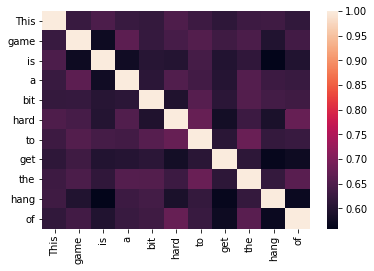

In [44]:
visualise_diffs(text1, com_model_embedding, com_tokenizer)

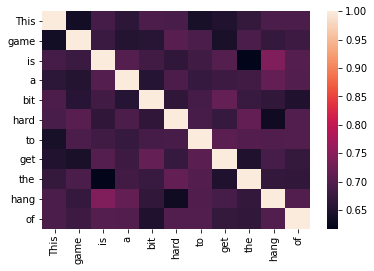

In [68]:
com_model_embedding_1 = RobertaModel.from_pretrained('output_gpt_text_1')
com_tokenizer_1 = RobertaTokenizer.from_pretrained('output_gpt_text_1')
visualise_diffs(text1, com_model_embedding_1, com_tokenizer_1)

In this section, we used three models in Section 3: all Amazon reviews, five-star reviews only and non-five-star reviews only. Then, we drew the heatmap respectively. Compared among these three heatmaps, we didn't see so much difference above the forementioned 2 heatmaps, which can be explained that there are a lot of overlapping in these two maps.